In [1]:
%matplotlib inline

import os
import sys
import logging
import codecs
import argparse
from functools import reduce
from imp import reload
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from jinja2 import Template

import utils3.plotting as pl
import utils3.metrics as mt
import utils3.filing as fl
import auto.auto_modeling as al
from utils3.data_io_utils import *

/Users/xiangyu/ENV3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/xiangyu/ENV3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
DATA_PATH = '/Users/xiangyu/Documents/NextCloud共享/Data_Science/分析文件/modeling/demo/01_data'
RESULT_PATH = '/Users/xiangyu/Documents/NextCloud共享/Data_Science/分析文件/modeling/demo/02_result'

In [3]:
var_dict = pd.read_excel(os.path.join(DATA_PATH, '建模代码可用变量字典.xlsx'))

In [4]:
all_x_y = load_data_from_pickle(DATA_PATH, 'all_x_y.pkl')

所有运行日志输出到以下日志文件中：
* 需关注ERROR级别和WARNING级别的日志
* INFO级别日志主要提供运行阶段信息和输出文档信息
* Level 18级别日志主要提供计算过程中详细的变量层级、模型层级或数据集层级的进度，当程序运行中断出现报错时可用来帮助定位问题是否出现在某一变量、模型或数据集

可在日志中搜索 ERROR、WARNING、INFO、Level 18等用于只显示相应级别的日志

In [5]:
logging.basicConfig(filename=os.path.join(RESULT_PATH, '自动建模运行日志.log'), level=18, 
                    filemode='w', format='[%(asctime)s] [%(levelname)s] %(message)s')

# 数据录入

录入的数据已经整理好，其中包含了以下columns

In [6]:
all_x_y.columns

Index(['apply_id', 'applicationdate', 'gamegroup', 'sample_set', 'Y_fid15',
       'Y_fid30', 'APP_RST', 'JAD1_SJS_route', 'applyDays',
       'applyID2DMDeviceIDNum',
       ...
       'tongdunPhoneMultiLoanNumAdjMean30D',
       'tongdunIdMultiLoanNumPfAdjMed30D', 'tongdunconfinNumPfL6MAdjMed30D',
       'tongdunNormalNumPfL6MAdjMed30D', 'tongdunP2PNumPfL6MAdjMed30D',
       'tongdunPhoneMultiLoanNumAdjMed30D', 'sh_X306', 'sh_X33', 'sh_X444',
       'sh_X600'],
      dtype='object', length=156)

数据的index必须是区分每条数据的唯一识别号。这里的数据中apply_id是唯一识别号

In [7]:
all_x_y.index = all_x_y.apply_id

非X数据的列

In [6]:
set(all_x_y.columns) - set(var_dict['指标英文'])

{'Y_fid15',
 'Y_fid30',
 'applicationdate',
 'apply_id',
 'gamegroup',
 'sample_set'}

确保数据每条是unique的

In [8]:
len(all_x_y.apply_id) == all_x_y.apply_id.nunique()

True

建模的Y是`Y_fid15`，准备数据的过程中有些样本的`Y_fid30`也成熟了，所以可以用来做后期的验证。近期申请的一些样本只有FID15+表现而没有FID30+表现的是backscore样本用来分析近期分数的稳定性

In [9]:
all_x_y[['Y_fid15', 'Y_fid30']].count()

Y_fid15    34713
Y_fid30    29551
dtype: int64

In [10]:
all_x_y.sample_set.value_counts()

MODELING_TRAIN    14880
OOT                8254
MODELING_TEST      6417
BACKSCORE          5162
Name: sample_set, dtype: int64

在这个时间段以下变量根据之前的一些经验知道是不能用的字段，或者已经有了更新版本的字段，而不需要老版本的数据

In [8]:
useless_vars = ['client', 'currentJobyear', 'monthIncome', 'mateNum',
    'tongdun6MIdSumLoanNumPf', 'tongdunPhoneMultiLoanNum', 'reLoan', 'up_consumeFreg',
    'up_consumeLineRate', 'up_consumeTop', 'up_creditCashAvg', 'up_post12ConsumeNum',
    'up_useCardAmountAvg', 'up_useCardLastTime', 'hd_longTimeSD3DayNum',
    'hd_longTimeSD7DayNum', 'hd_contactEarlyMorningRate', 'hd_onlineDuration']

因为知道以前的模型选中了以下变量，所以在做eda的时候这些指标即使可能因为不达标会被删除，也将会被豁免而保留下来

In [9]:
exempt_vars = ['deviceModelByApplyID', 'dhb_callTelTotalNumColl3W', 'dhb_callTelTotalNumCollHist',
'gaodeCustmizeScore', 'hd_maxOfflineDaysIn3Months', 'hd_plan_amt_recent_v2', 'rm_zx_dept_cnt_1m',
'td_nightLoanAll60dRatioFreq', 'tencentScore', 'up_creditCashAvg_v2', 'xy_behaviorFailPayNumHist',
'xy_behaviorSuccessPayNumHist', 'zrobot_pg_score', 'nike700Score']

In [10]:
x_cols = list(set(all_x_y.columns).intersection(var_dict['指标英文'].unique()))

须确保这些指标在x数据里面

In [9]:
len(useless_vars) == len(set(useless_vars).intersection(x_cols))

False

In [10]:
len(exempt_vars) == len(set(exempt_vars).intersection(x_cols))

False

In [11]:
useless_vars = [i for i in useless_vars if i in x_cols]
exempt_vars = [i for i in exempt_vars if i in x_cols]


# 建模准备参数

In [12]:
ranking_args_dict = {
    'random_forest': {
        'grid_search': False,
        'param': None
    },
    'xgboost': {
        'grid_search': False,
        'param': None
    }
}

# 为了demo能迅速执行完，只选择random_forest
ranking_methods = [
    'random_forest',
#     'lasso', 
    # 'xgboost'
]

xgbparams_selection_method = ['XGBExp']#, 'XGBGrid', 'XGBRandom']



In [13]:
xgb_params_range = {
            'learning_rate': [0.03, 0.05,0.1,0.2],
            'max_depth': [2,3,4,5],
            'gamma': [0, 0.05, 0.1],
            'min_child_weight':[1,3],
            # 'subsample': np.linspace(0.4, 0.7, 3),
            # 'colsample_bytree': np.linspace(0.4, 0.7, 3),
        }


In [14]:
xgb_param_experience = {
            'max_depth': 2,
            'min_samples_leaf ': 200,
             'eta': 0.1,
             'objective': 'binary:logistic',
             'subsample': 0.8,
             'colsample_bytree': 0.8,
             'gamma': 0,
             'silent': 0,
             'eval_metric':'auc'
        }

In [15]:

params = {
'all_x_y': all_x_y,
'var_dict': var_dict,
'x_cols': x_cols,
'y_col': 'Y_fid15',
'useless_vars': useless_vars,
'exempt_vars': exempt_vars,
'ranking_args_dict': ranking_args_dict,
'ranking_methods': ranking_methods,
#
'DATA_PATH': DATA_PATH,
'RESULT_PATH': RESULT_PATH,
'SAVE_LABEL': 'demo',
'TIME_COL': 'applicationdate',
'TRAIN_SET_NAME': 'MODELING_TRAIN',
'TEST_SET_NAME': 'MODELING_TEST',
'OOT_SET_NAME': 'OOT',
# 可填
'NFOLD': 5,
'uniqvalue_cutoff': 0.97,
'missingrate_cutoff': 0.90,
'badrate_cutoff': 0.90,
'xgbparams_selection_method': xgbparams_selection_method,
'KEPT_LIMIT': 50,
'xgb_params_range': xgb_params_range,
'xgb_param_experience': xgb_param_experience
}


# EDA

In [20]:
step1_obj = al.StepOneEDA(params)
step1_obj.run()

# 变量选择

In [16]:
step2_obj = al.StepTwoVarSelect(params)
step2_obj.variable_ranking(bin20=False)
step2_obj.variable_filter(total_topn=50, source_topn=5, cluster_topn=5,
                          iv_threshold=0.3, corr_threshold=0.7,
                          vif_threshold=10)

/Users/xiangyu/Documents/repos/genie/utils3/metrics.py:624: RuntimeWarning: divide by zero encountered in log
  woe = np.log(dd2['PercentBad'] / dd2['PercentGood'])


# 变量粗分箱 - 如果不粗分箱可跳过

In [17]:
# 如果为第一次粗分箱
cols_filter = load_data_from_json(params['RESULT_PATH'], 'variable_filter.json')
auto_rebin_spec = load_data_from_pickle(params['DATA_PATH'], '建模细分箱10结果.pkl')['rebin_spec']
rebin_spec = {k:v for k,v in auto_rebin_spec.items() if k in cols_filter['ranking_kept']}



In [18]:
# 如果已经粗分箱过，需要在这个基础上调整
rebin_spec = load_data_from_pickle(params['DATA_PATH'], 'coarse_classing_rebin_spec.pkl')


In [21]:
ui_obj = pl.BinPlotAdjustUI(step2_obj.X_train[cols_filter['ranking_kept']],
                            step2_obj.y_train,
                            params['RESULT_PATH'],
                            params['DATA_PATH'],
                            rebin_spec, params['var_dict'])
ui_obj.main_ui(list(rebin_spec.keys()))

按照时间维度生成排序对比表，确保在时间维度上排序性稳定。如果有不稳定，可以返回上一步继续调整粗分箱。执行完输出文件为『变量粗分箱按时间维度对比逾期率排序性.xlsx』

In [22]:
step3_obj = al.StepThreeCoarseCheck(params)
step3_obj.compare_trend_over_time()

确认变量逾期率排序没有问题后。如果有无论怎么调整分箱，按时间维度排序性都不稳定决定放弃的的指标，则将其作为输入放入以下 `trend_not_ok_exclude` 中

In [23]:
# 假设我看完上面输出的文档结果，觉得2个字段按照时间维度看逾期率不是很稳定，打算剔除
trend_not_ok_exclude = ['hd_numberOfCallsWithBankIn3Months', 'applyDays']
step3_obj.output(trend_not_ok_exclude)

/Users/xiangyu/Documents/repos/genie/utils3/metrics.py:624: RuntimeWarning: divide by zero encountered in log
  woe = np.log(dd2['PercentBad'] / dd2['PercentGood'])


# 建模

In [19]:
step4_obj = al.StepFourTrain(params)

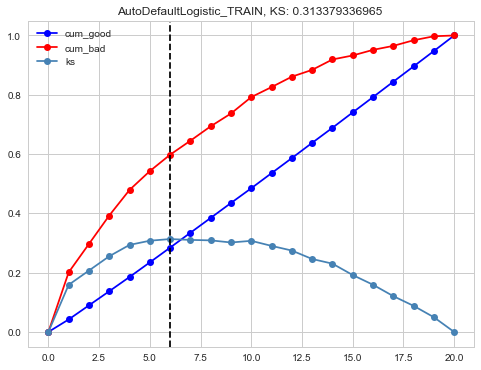

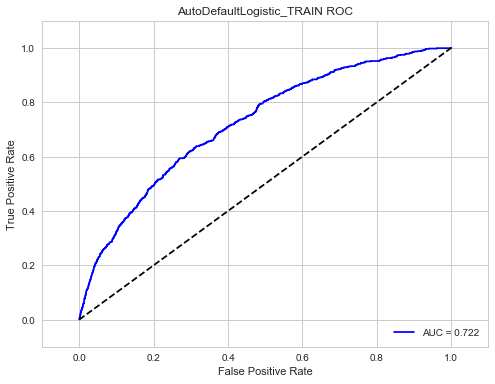

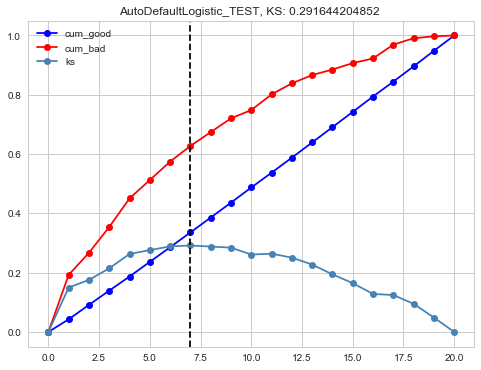

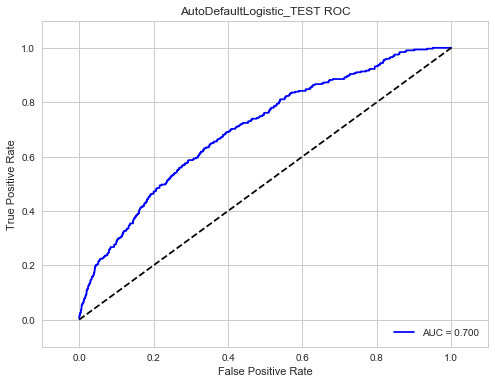

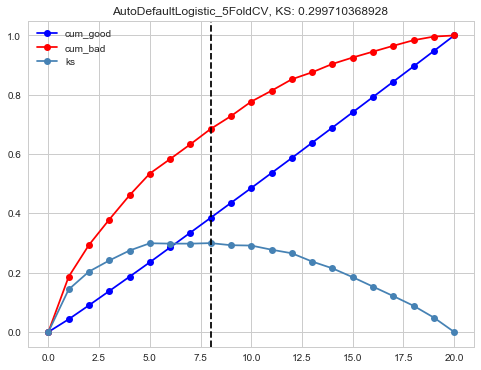

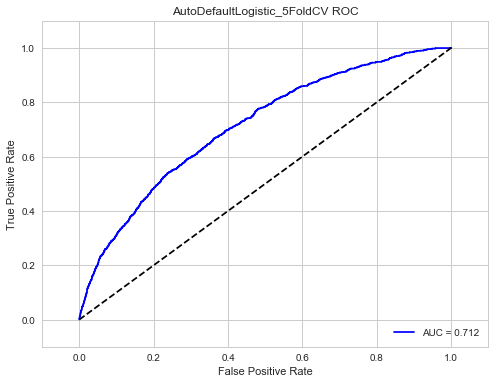

In [20]:
step4_obj.run(model_names=['logistic'])

/Users/xiangyu/Documents/repos/genie/utils3/metrics.py:624: RuntimeWarning: divide by zero encountered in log
  woe = np.log(dd2['PercentBad'] / dd2['PercentGood'])


[0]	train-auc:0.627117	test-auc:0.6068
[10]	train-auc:0.698179	test-auc:0.654934
[20]	train-auc:0.729556	test-auc:0.667741
[30]	train-auc:0.762087	test-auc:0.679356
[40]	train-auc:0.787969	test-auc:0.688675
[50]	train-auc:0.811086	test-auc:0.699507
[60]	train-auc:0.826316	test-auc:0.705898
[70]	train-auc:0.83967	test-auc:0.711945
[80]	train-auc:0.850538	test-auc:0.713803
[90]	train-auc:0.859589	test-auc:0.715325
[100]	train-auc:0.867727	test-auc:0.716532
[110]	train-auc:0.875299	test-auc:0.71753
[120]	train-auc:0.881376	test-auc:0.717258
[130]	train-auc:0.88768	test-auc:0.718223
[140]	train-auc:0.893688	test-auc:0.719941
[150]	train-auc:0.898884	test-auc:0.720192
[160]	train-auc:0.902917	test-auc:0.719836
[170]	train-auc:0.907556	test-auc:0.71894
[0]	train-auc:0.551813	test-auc:0.534605
[10]	train-auc:0.682619	test-auc:0.653853
[20]	train-auc:0.701964	test-auc:0.661026
[30]	train-auc:0.720492	test-auc:0.671385
[40]	train-auc:0.73561	test-auc:0.682829
[50]	train-auc:0.751598	test-auc:0.

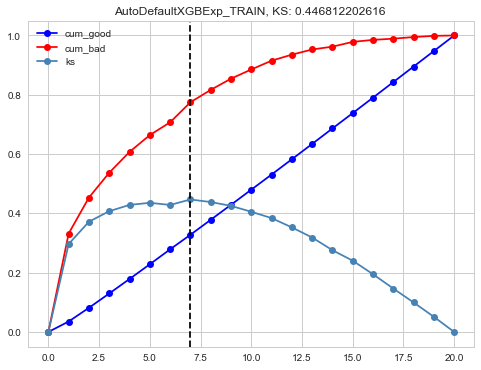

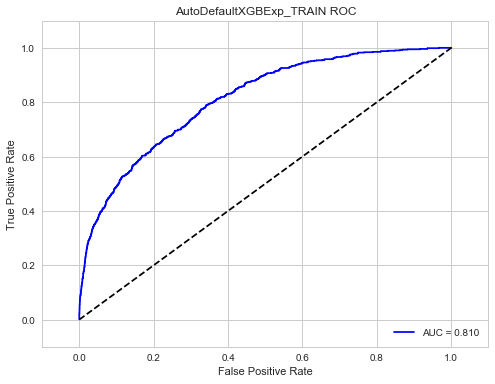

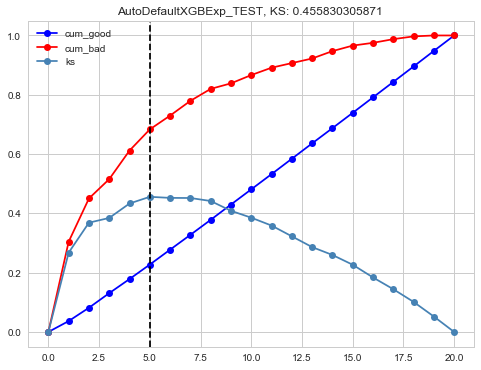

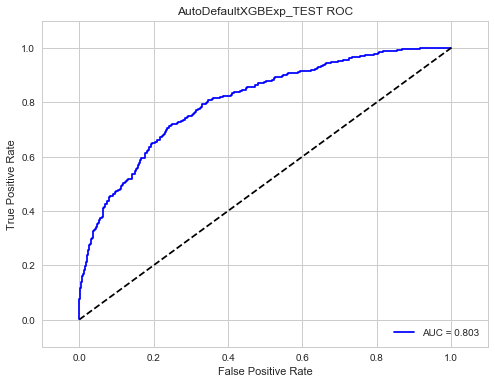

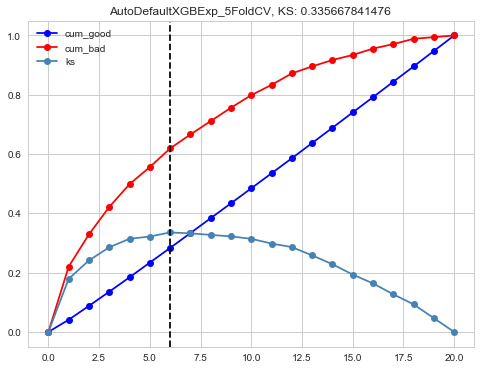

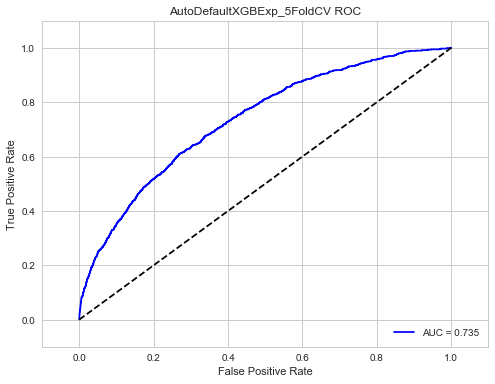

In [67]:
step4_obj.run(model_names=['xgboost'])

# 验证

准备验证用的参数

In [22]:
union_var_list = pd.read_excel(os.path.join(RESULT_PATH, 'AutoDefaultLogistic_train_coef.xlsx')).index
union_var_list = [i for i in union_var_list if i != 'const']

In [23]:
coarse_classing_rebin_spec = load_data_from_pickle(DATA_PATH, 'coarse_classing_rebin_spec.pkl')
data_cat_dict = {}
for set_name in all_x_y.sample_set.unique():
    sub_dd = all_x_y.loc[all_x_y.sample_set==set_name, union_var_list].copy()
    data_cat_dict[set_name] = mt.BinWoe().convert_to_category(sub_dd, var_dict, coarse_classing_rebin_spec)


In [24]:
liftcurve_name_map = {
    'AutoDefaultLogistic':'V5FID15Logistic', 
    'AutoDefaultXGBExp':'V5FID15XGBExp', 
    'AutoDefaultXGBRandom':'V5FID15XGBRand', 
    'AutoDefaultXGBGrid':'V5FID15XGBGrid' 
}

In [25]:
backscore_has_perf = all_x_y.loc[(all_x_y.sample_set=='BACKSCORE')&(all_x_y.Y_fid15.notnull()), 'apply_id'].unique()

In [31]:
# SQL = """
# SELECT apply_id, score
# FROM hive_pro.hdp_data_posp.hdp_s_v5fid7atlas_score201803150503
# WHERE apply_id IN {{ apply_list }}
# """
# base_model_score = {}
# for set_name in all_x_y.sample_set.unique():
#     set_apply = all_x_y.loc[all_x_y.sample_set==set_name, 'apply_id'].unique()
#     dd = presto_read_sql_df(Template(SQL).render(apply_list=tuple(set_apply)))
#     dd.index = dd.apply_id
#     dd = dd.score
#     base_model_score[set_name] = dd

# save_data_to_pickle(base_model_score, DATA_PATH, 'base_model_score.pkl')

In [26]:
base_model_score = load_data_from_pickle(DATA_PATH, 'base_model_score.pkl')

In [27]:
xgboost_data_dict = {}
cols_filter = load_data_from_json(RESULT_PATH, 'variable_filter.json')
candidate_selected = cols_filter['coarsebin_kept_after_ranking']
xgb_selected = cols_filter['xgboost_selected']
auto_rebin_spec = load_data_from_pickle(DATA_PATH, 'AutoDefault_XGBoost输出数据和分箱明细.pkl')['auto_rebin_spec']
bin_to_label = load_data_from_pickle(DATA_PATH, 'AutoDefault_XGBoost输出数据和分箱明细.pkl')['bin_to_label']


In [28]:
for set_name in all_x_y.sample_set.unique():
    sub_dd = all_x_y.loc[all_x_y.sample_set==set_name, candidate_selected].copy()
    xgboost_data_dict[set_name] = mt.BinWoe().apply_xgboost_data_derive(sub_dd, var_dict, 
                                                                        auto_rebin_spec, 
                                                                        bin_to_label, 
                                                                        verbose=True).loc[:, xgb_selected]


In [29]:
params_verify = {
'data_cat_dict': data_cat_dict,
'xgboost_data_dict': xgboost_data_dict,
'var_dict': var_dict,
'all_Y': all_x_y[['Y_fid15', 'Y_fid30']],
'y_cols': ['Y_fid15', 'Y_fid30'],
'union_var_list': union_var_list,
'model_labels': ['AutoDefaultLogistic', 'AutoDefaultXGBExp'],# 'AutoDefaultXGBRandom', 'AutoDefaultXGBGrid'],
'coarse_classing_rebin_spec': coarse_classing_rebin_spec,
'liftcurve_name_map': liftcurve_name_map,
#
'TRAIN_SET_NAME': 'MODELING_TRAIN',
'TEST_SET_NAME': 'MODELING_TEST',
'OOT_SET_NAME': 'OOT',
'BACKSCORE_SET_NAME': 'BACKSCORE',
'DATA_PATH': DATA_PATH,
'RESULT_PATH': RESULT_PATH,
'WOE_FILE_NAME': 'woe_iv_df_coarse.xlsx',
'Y_BUILD_NAME': 'Y_fid15',
#可选
'backscore_has_perf': backscore_has_perf,
'base_model_score': base_model_score,
'BASE_MODEL_LABEL': 'V5FID7',
}

In [30]:
step5_obj = al.StepFiveVerify(params_verify)
step5_obj.run()

/Users/xiangyu/Documents/repos/genie/utils3/metrics.py:1446: RuntimeWarning: divide by zero encountered in log
  psi_index_value = (np.log(combined.after_pct/combined.before_pct) * (combined.after_pct - combined.before_pct))
/Users/xiangyu/Documents/repos/genie/utils3/metrics.py:624: RuntimeWarning: divide by zero encountered in log
  woe = np.log(dd2['PercentBad'] / dd2['PercentGood'])


# 部署

In [34]:
step6_obj = al.StepSixDeploy(DATA_PATH, RESULT_PATH)

## 计算新样本的分数

比如需要计算最近2周的数据的分数。以下例子所用的数据是已经计算好分数的数据，只是为了demo展示.新数据集的分数会和其他数据集一起存到分数的pkl文件中

In [21]:
step6_obj.generate_score('AutoDefaultLogistic', data_cat_dict['BACKSCORE'], 'RECENT2WK')

In [68]:
step6_obj.generate_score('AutoDefaultXGBExp', xgboost_data_dict['BACKSCORE'], 'RECENT2WK')

## 上传分数至数据库

In [22]:
liftcurve_name_map

{'AutoDefaultLogistic': 'V5FID15Logistic',
 'AutoDefaultXGBExp': 'V5FID15XGBExp',
 'AutoDefaultXGBGrid': 'V5FID15XGBGrid',
 'AutoDefaultXGBRandom': 'V5FID15XGBRand'}

In [23]:
step6_obj.upload_score_to_database_for_risk('AutoDefaultLogistic', liftcurve_name_map, 'MODELING_TRAIN')

## 评分卡部署

In [8]:
coarse_classing_rebin_spec = load_data_from_pickle(DATA_PATH, 'coarse_classing_rebin_spec.pkl')

In [9]:
production_name_map = {
    'province': 'province_v2',
    'rm_zx_unsec_os_amt': 'rm_zx_unsec_os_amt_v2'
}

In [42]:
step6_obj.generate_scorecard_deployment_documents(model_label='AutoDefaultLogistic', 
                                                  live_abbr='v5fid15',
                                                  y_col='Y_fid15', 
                                                  train_set_name='MODELING_TRAIN',
                                                  eda_file_name='demo_variables_summary.xlsx', 
                                                  coarse_classing_rebin_spec=coarse_classing_rebin_spec,
                                                  production_modelName='xjdH5Score', 
                                                  product_name='walletH5Credit',
                                                  liftcurve_name_map=liftcurve_name_map, 
                                                  production_name_map=production_name_map)

## XGBoost部署

In [ ]:
production_name_map = {
    'province': 'province_v2',
    'rm_zx_unsec_os_amt': 'rm_zx_unsec_os_amt_v2'
}

In [32]:
step6_obj.generate_xgb_deployment_documents(model_label='AutoDefaultXGBExp', 
                                            live_abbr='v5fid15', y_col='Y_fid15', 
                                            train_set_name='MODELING_TRAIN',
                                            eda_file_name='demo_variables_summary.xlsx', 
                                            var_dict=var_dict, model_label_version='AutoDefault',
                                            liftcurve_name_map=liftcurve_name_map, 
                                            production_name_map=production_name_map)

# 生成报告文档

生成报告文档，以逻辑回归评分卡为例

In [46]:
FINAL_REPORT_PATH = '/Users/xiangyu/Documents/Seafile/分析文件/modeling/demo/03_最终文档'

In [50]:
train_coef = pd.read_excel(os.path.join(RESULT_PATH, 'AutoDefaultLogistic_train_coef.xlsx'))
test_coef = pd.read_excel(os.path.join(RESULT_PATH, 'AutoDefaultLogistic_test_coef.xlsx'))

combined_coef = train_coef.reset_index()\
                    .merge(test_coef.reset_index(), on=['index', '指标中文'], suffixes=('_TRAIN', '_TEST'))
combined_coef = combined_coef.rename(columns={'index': '指标英文'})

In [51]:
swap_analysis = pd.read_excel(os.path.join(RESULT_PATH, '对比模型SWAP_ANALYSIS.xlsx'), sheetname=None)

In [53]:
# python3.6的dict是ordered，按照顺序这样定义，之后生成excel的时候会按照顺序穿件sheet
data_dic = {}
# 如果sheet对应的内容是dict，则dict的key会出现在sheet第一列。value会从第二列开始插入
data_dic['01_模型结果'] = {
    '模型表现汇总': pd.read_excel(os.path.join(RESULT_PATH, 'all_ksauc_perf_summary.xlsx')),
    '模型系数': combined_coef,
    #如果是图片的话必须key值中包含'_picture'，然后value为figure_path下面的图存储路径和文件名 
    'TRAIN_KS_picture': 'KS/AutoDefaultLogistic_TRAIN_KS.png', 
    'TEST_KS_picture': 'Ks/AutoDefaultLogistic_TEST_KS.png', 
    'TRAIN_AUC_picture': 'AUC/AutoDefaultLogistic_TRAIN_AUC.png', 
    'TEST_AUC_picture': 'AUC/AutoDefaultLogistic_TEST_AUC.png'    
}
data_dic['02_LiftCurve'] = {
    #如果是图片的话必须key值中包含'_picture'，然后value为figure_path下面的图存储路径和文件名 
    'liftcurves OOT Y_FID15_picture': 'liftcurve_OOT_Y_fid15.png', 
    'liftcurves OOT Y_FID30_picture': 'liftcurve_OOT_Y_fid30.png'  
}
data_dic['03_SWAP_Analysis'] = swap_analysis
data_dic['04_模型通过率&逾期率模拟'] = {
    'V5FID15Logistic模型': 'approval_rate_anaysis_AutoDefaultLogistic.png',
    'V5FID15XGB经验参数模型': 'approval_rate_anaysis_AutoDefaultXGBExp.png',
}
# 如果sheet对应的内容是df，则从sheet的A1位置开始插入整张表格，不包含pd.DataFrame的index
data_dic['细节1_变量EDA&变量筛选原因'] = pd.read_excel(os.path.join(RESULT_PATH, 'demo_variables_summary.xlsx'))
data_dic['细节2_粗分箱'] = pd.read_excel(os.path.join(RESULT_PATH, 'woe_iv_df_coarse.xlsx'))
data_dic['细节3_变量PSI'] = pd.read_excel(os.path.join(RESULT_PATH, 'all_variable_psi.xlsx'))
data_dic['细节4_分数PSI'] = pd.read_excel(os.path.join(RESULT_PATH, 'all_model_score_psi.xlsx'))
data_dic['细节4_分数Deciles'] = pd.read_excel(os.path.join(RESULT_PATH, 'all_decile.xlsx'))
data_dic['细节4_变量逾期率排序性对比'] = {
    'TRAIN vs OOT Y_FID15': pd.read_excel(os.path.join(RESULT_PATH, '变量Y_fid15逾期率对比MODELING_TRAINVsOOT.xlsx')),
    'TRAIN vs OOT Y_FID30': pd.read_excel(os.path.join(RESULT_PATH, '变量Y_fid30逾期率对比MODELING_TRAINVsOOT.xlsx')),
}

                                     

In [60]:
fl.ModelSummary2Excel(FINAL_REPORT_PATH, os.path.join(RESULT_PATH, 'figure'), 
                   'DRM-A-V5FID15DEMO模型文档.xlsx', data_dic).run()